In [2]:
%matplotlib inline
import seaborn as sns
import pymc3 as pm
from dirichlet_multinomial import DirichletMultinomial
import numpy as np
from numpy import random as nr

### Generate simple data (n constant)

In [28]:
alphas = np.array([5, 7, 1, 0.5])
print('alpha:')
print(alphas)
print('normalized:')
print(alphas/alphas.sum())
#alphas = alphas * 200
ndraws = 2000
N = 200
dirichlets = np.array([nr.dirichlet(alphas) for i in range(N)])
print(dirichlets)
data = np.array([nr.multinomial(ndraws, p) for p in dirichlets])

alpha:
[ 5.   7.   1.   0.5]
normalized:
[ 0.37037037  0.51851852  0.07407407  0.03703704]
[[  2.34091357e-01   7.16829220e-01   2.30252185e-03   4.67769011e-02]
 [  2.44918809e-01   6.41980263e-01   7.93991834e-02   3.37017444e-02]
 [  3.95599440e-01   5.87969213e-01   6.11597168e-03   1.03153759e-02]
 [  4.51356459e-01   4.96838414e-01   3.10767516e-02   2.07283762e-02]
 [  3.67331364e-01   5.48666514e-01   3.73199959e-02   4.66821259e-02]
 [  3.50852096e-01   6.22290797e-01   2.51261887e-02   1.73091832e-03]
 [  4.16482558e-01   4.02893535e-01   1.64882172e-01   1.57417355e-02]
 [  2.74618225e-01   4.39255025e-01   2.07055387e-01   7.90713629e-02]
 [  3.34590406e-01   3.53863595e-01   3.11364748e-01   1.81251420e-04]
 [  3.24279853e-01   5.04783430e-01   1.69985797e-01   9.50919415e-04]
 [  4.03680264e-01   5.79973559e-01   1.35325622e-02   2.81361550e-03]
 [  3.68241828e-01   6.03521086e-01   2.72372249e-02   9.99860414e-04]
 [  5.48860989e-01   3.93516438e-01   3.72103855e-02   2.

### Test explicit model

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 2.6317e+06:  17%|█▋        | 34752/200000 [00:23<01:46, 1544.40it/s]
Convergence archived at 34900
Interrupted at 34,900 [17%]: Average Loss = 2.6495e+06
100%|█████████▉| 999/1000 [00:28<00:00, 89.45it/s]/home/labs/elinav/maxh/miniconda3/envs/bayesian_microbiome/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 15 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:28<00:00, 35.52it/s]



alphas:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.082            0.330            0.024            [4.354, 5.663]
  6.859            0.458            0.034            [5.827, 7.766]
  0.956            0.065            0.004            [0.833, 1.076]
  0.470            0.031            0.001            [0.418, 0.538]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  4.429          4.864          5.083          5.293          5.758
  5.891          6.580          6.882          7.151          7.857
  0.834          0.912          0.954          0.999          1.084
  0.408          0.450          0.468          0.492          0.533



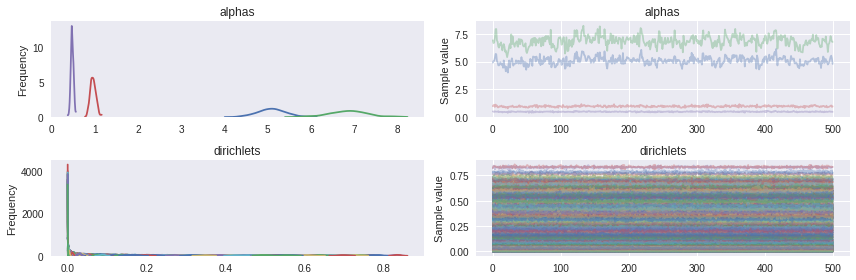

In [29]:
with pm.Model() as model:
    lowerbound = pm.Bound(pm.Flat, lower=0)
    a = lowerbound('alphas', shape=len(alphas))
    d = pm.Dirichlet('dirichlets', a, shape=(N, len(alphas)))
    obs = pm.Multinomial('data', n=ndraws,p=d, observed=data)

with model:
    trace = pm.sample()
    pm.traceplot(trace)
    pm.summary(trace, ['alphas'])

### Test implicit model

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 7.4542e+07:   6%|▌         | 11561/200000 [00:04<01:08, 2757.29it/s]
Convergence archived at 11800
Interrupted at 11,800 [5%]: Average Loss = 7.458e+07
100%|██████████| 1000/1000 [00:04<00:00, 211.12it/s]



alphas:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.018            0.025            0.002            [4.960, 5.063]
  6.780            0.034            0.002            [6.706, 6.843]
  0.946            0.005            0.000            [0.937, 0.956]
  0.465            0.002            0.000            [0.461, 0.470]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  4.966          5.002          5.017          5.034          5.069
  6.711          6.758          6.779          6.802          6.851
  0.937          0.943          0.946          0.949          0.957
  0.461          0.464          0.465          0.467          0.470



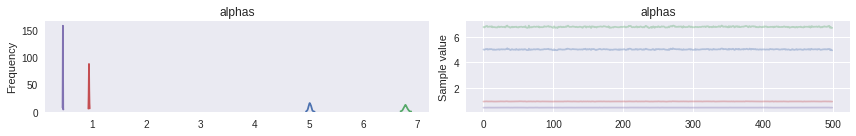

In [30]:
with pm.Model() as implicit_model:
    lowerbound = pm.Bound(pm.Flat, lower=0)
    a = lowerbound('alphas', shape=len(alphas))
    obs = DirichletMultinomial('data', n=np.array([ndraws]*N, dtype=np.uint), a=a, observed=data)

with implicit_model:
    implicit_trace = pm.sample()
    pm.traceplot(implicit_trace)
    pm.summary(implicit_trace, ['alphas'])

## Compare to BetaBinomial

### Generate Data

In [37]:
N = 2000
ps = nr.beta(1.5, 0.5, size=N)
data_binomial = np.array([nr.binomial(ndraws/4, p) for p in ps])
data_binomial

array([470, 267, 499, ..., 492, 499, 452])

### Test explicit model

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 11,515: 100%|██████████| 200000/200000 [04:17<00:00, 775.65it/s]  
Finished [100%]: Average Loss = 11,515
100%|█████████▉| 998/1000 [00:43<00:00, 33.85it/s]/home/labs/elinav/maxh/miniconda3/envs/bayesian_microbiome/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 155 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:43<00:00, 23.15it/s]



a:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.456            0.049            0.003            [1.359, 1.547]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.360          1.426          1.456          1.486          1.553


b:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.500            0.013            0.001            [0.473, 0.524]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.475          0.490          0.499          0.509          0.526



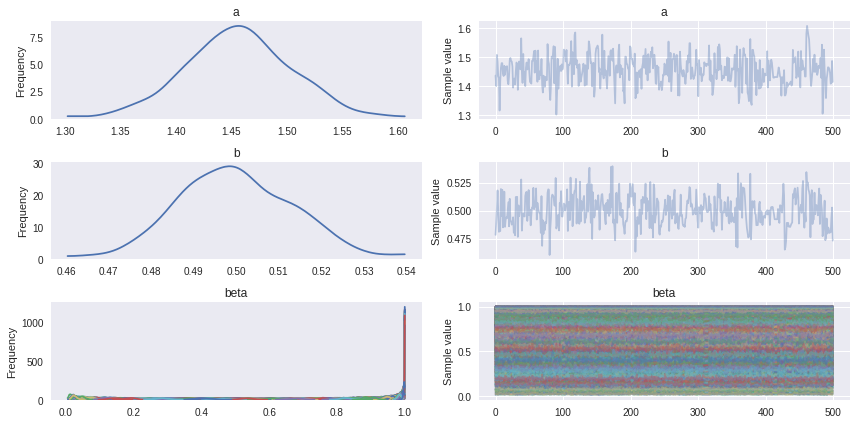

In [38]:
with pm.Model() as explicit_binom_model:
    lowerbound = pm.Bound(pm.Flat, lower=0)
    a = lowerbound('a')
    b = lowerbound('b')
    ps = pm.Beta('beta', a, b, shape=N)
    obs = pm.Binomial('data', n=ndraws/4, p=ps, observed = data_binomial)


with explicit_binom_model:
    explicit_binom_trace = pm.sample()
    pm.traceplot(explicit_binom_trace)
    pm.summary(explicit_binom_trace, ['a', 'b'])

### Test implicit model

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 11,556:  10%|▉         | 19896/200000 [00:30<04:33, 657.55it/s]
Convergence archived at 19900
Interrupted at 19,900 [9%]: Average Loss = 12,118
100%|██████████| 1000/1000 [00:45<00:00, 26.22it/s]/home/labs/elinav/maxh/miniconda3/envs/bayesian_microbiome/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 190 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))




a:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.454            0.049            0.003            [1.353, 1.540]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.358          1.420          1.454          1.487          1.546


b:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.500            0.014            0.001            [0.473, 0.526]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.474          0.490          0.499          0.509          0.529



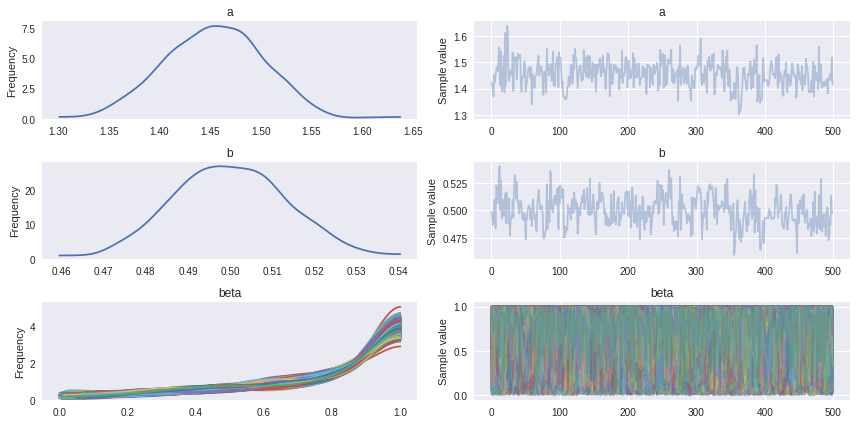

In [39]:
with pm.Model() as implicit_binom_model:
    lowerbound = pm.Bound(pm.Flat, lower=0)
    a = lowerbound('a')
    b = lowerbound('b')
    ps = pm.Beta('beta', a, b, shape=N)
    obs = pm.BetaBinomial('data', n=ndraws/4, alpha=a, beta=b, observed = data_binomial)


with implicit_binom_model:
    implicit_binom_trace = pm.sample()
    pm.traceplot(implicit_binom_trace)
    pm.summary(implicit_binom_trace, ['a', 'b'])